In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, log_loss, precision_score
from pandas import DataFrame, concat
from numpy.random import seed
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from catboost import Pool
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.preprocessing import PolynomialFeatures
import shap
import datetime
import matplotlib.pyplot as plt
from numpy import max
from pandasql import sqldf
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
experiment_model = CatBoostRegressor()
# df = pd.read_csv("../data/interim/cat3_over_estimations/data.csv")
# df = pd.read_csv("../data/raw/total_combos/1.csv")
dfs = []
for i in range(1,6):
    temp_df = pd.read_csv("../data/raw/total_combos/{}.csv".format(i))
    dfs.append(temp_df)
    if i % 100 == 0:
        print(i)
df = pd.concat(dfs, axis=0)

df["a_problem"] = df["target"].apply(lambda x: 1 if x >= 20 else 0)


/Users/petermyers/Desktop/Code/commons/venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/petermyers/Desktop/Code/commons/venv/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "Yo

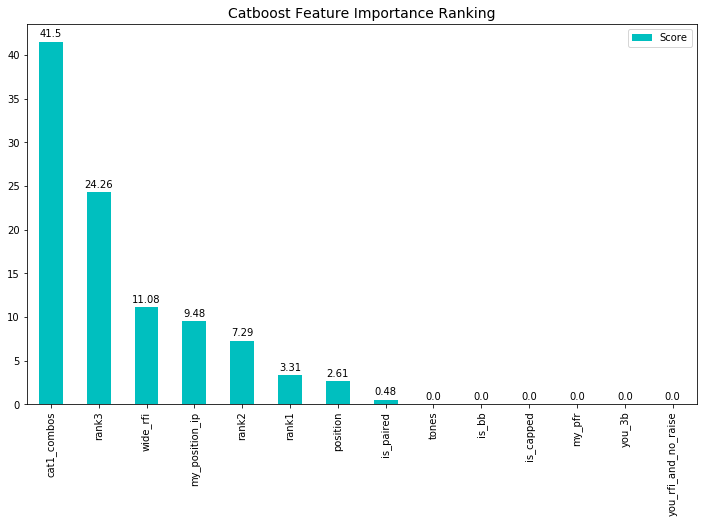

In [2]:

seed(42)
temp_df = df.copy()
# temp_df = df.sample(100000)
temp_df = df[df["position"] != "You Cold 4Bet"]
temp_df = df[df["position"].isin(["LJ RFI", "HJ RFI", "CO RFI"])]
# X = temp_df.drop(["target", "position"], axis=1)
X = temp_df.drop(["a_problem", "target", "range", "top_range"], axis=1)
y = temp_df[["a_problem"]]


# X = X[important_columns]
cat_features = [6]

# Get shap dataframes
X = DataFrame(X, columns=X.columns)

# Fit the model on the training set
experiment_model.fit(X, y, cat_features=cat_features, logging_level='Silent')

feature_score = pd.DataFrame(list(zip(X.dtypes.index, experiment_model.get_feature_importance(Pool(X, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()


In [3]:
df.groupby(["position"])["a_problem"].sum()

position
BN RFI                                11
CO RFI                               113
CO RFI and You BB Call                 0
HJ RFI                               192
LJ RFI                               241
SB RFI                                 0
Villain BN RFI and You BB Call         0
Villain HJ RFI and You BB Call        25
Villain LJ RFI and You BB Call        19
Villain RFI and You Call (Not BB)     11
Villain SB RFI and You BB Call         0
Name: a_problem, dtype: int64

In [4]:
pred_y = experiment_model.predict(X)
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(pred_y, y))
print(score)

0.015924539745054585


In [5]:
# Get important columns
importance_threshold = 7
important_columns = []
for i, x in zip((feature_score['Score'].round(2) > importance_threshold).index, (feature_score['Score'].round(2) > importance_threshold)):
    if x:
        important_columns.append(X.columns[i])
print("important_columns:", important_columns)


important_columns: ['cat1_combos', 'rank3', 'wide_rfi', 'my_position_ip', 'rank2']


In [6]:
import numpy as np
from pandas import read_csv
from numpy.random import seed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
warnings.filterwarnings("ignore")

import shap
import pandas as pd
from numpy import cumsum
from xgboost import XGBClassifier

seed(40)

# shap values
shap_values = shap.TreeExplainer(experiment_model).shap_values(X[0:10000])

sorted_feature_importance = pd.DataFrame(shap_values, columns=X.columns).abs().sum().sort_values(ascending=False)
cumulative_sum = cumsum([y for (x,y) in sorted_feature_importance.reset_index().values])
gt_999_importance = cumulative_sum / cumulative_sum[-1] > .999
nth_feature = min([y for (x,y) in zip(gt_999_importance, zip(range(len(gt_999_importance)))) if x])[0]
important_columns = sorted_feature_importance.iloc[0:nth_feature+1].index.values.tolist()
print(important_columns)

plt.clf()
shap.summary_plot(shap_values, X[0:10000])



CatBoostError: Bad value for num_feature[0,6]="LJ RFI": Cannot convert 'b'LJ RFI'' to float

- Primary
    - **When IP:** Lower
- Secondary
    - **If Capped Range**: Lower
    - **You have a wide range**: Lower    
    - **If RFI and No Raisers**: Higher
    - **High Rank1**: Higher


## Decision Tree with these 5 features

In [ ]:
def remove_everything(string):
    return string.replace("\n0 [","").replace("label=\"","").replace('"] ', '').replace('value = ', ''). \
                  replace('10.5', 'T'). \
                  replace('11.5', 'J'). \
                  replace('12.5', 'Q'). \
                  replace('13.5', 'K'). \
                  replace('samples = ', '')


In [ ]:
print(dot_data)

In [ ]:
dot_data.split(";")[2].split("\\n")[3]

In [ ]:
remove_everything(dot_data.split(";")[2][5:].split("\\n")[1])

In [ ]:
clf2.tree_.samples[0]

ValueError: Cannot take a larger sample than population when 'replace=False'

score: 0.45825756949558394
score: 0.0
score: 0.0
score: 0.0
score: 0.0
score: 0.0
score: 0.0


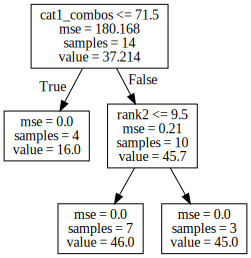

In [41]:
# Get important columns
# importance_threshold = 9
# important_columns = []
# for i, x in zip((feature_score['Score'].round(2) > importance_threshold).index, (feature_score['Score'].round(2) > importance_threshold)):
#     if x:
#         important_columns.append(X.columns[i])
# print("important_columns:", important_columns)

# temp_df = df.sample(2000000)
temp_df = df.copy()

temp_df1 = sqldf("""
SELECT *
FROM temp_df
WHERE position IN ("CO RFI", "LJ RFI", "HJ RFI", "Villain LJ RFI and You BB Call", "Villain HJ RFI and You BB Call")
and CASE 
      WHEN position = "CO RFI" THEN cat1_combos >= 84*0.8
      WHEN position = "HJ RFI" THEN cat1_combos >= 68*0.8
      WHEN position = "LJ RFI" THEN cat1_combos >= 58*0.8
      WHEN position = "Villain LJ RFI and You BB Call" THEN cat1_combos >= 68*0.8
      WHEN position = "Villain HJ RFI and You BB Call" THEN cat1_combos >= 84*0.8      
    END

""", globals())

temp_df_new = temp_df1[temp_df1["position"].isin(["Villain HJ RFI and You BB Call"])].drop(["a_problem", "position", "range", "top_range"], axis=1) # [["rank1", "my_position_ip", "target"]]

train, test = train_test_split(temp_df_new, test_size=0.40)


train_X = train.drop(["target"], axis=1)
train_y = train[["target"]]
test_X = test.drop(["target"], axis=1)
test_y = test[["target"]]
min_samples_split = int(train_X.shape[0]*0.3)


from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree, linear_model
%matplotlib inline
for i in range(1,7):
    clf2 = tree.DecisionTreeRegressor(max_depth=i, min_samples_split=min_samples_split)
    clf2.fit(train_X, train_y)
    pred_y = clf2.predict(test_X)
    from sklearn.metrics import mean_squared_error
    score = np.sqrt(mean_squared_error(pred_y, test_y))
    print("score:", score)
    # clf2.coef_

CHOICE = 5

clf2 = tree.DecisionTreeRegressor(max_depth=CHOICE, min_samples_split=min_samples_split)
clf2.fit(train_X, train_y)
pred_y = clf2.predict(train_X)
from sklearn.metrics import mean_squared_error
print("score:", score)
dot_data = export_graphviz(clf2, out_file=None, feature_names=train_X.columns)
graph = Source(dot_data)
graph.render("graph")        
graph
# clf2.coef_    


In [45]:
temp_df_new["cat1_groups"] = pd.cut(temp_df_new['cat1_combos'], bins=[0,20,85,1000])
temp_df_new.head()
temp_df_new.groupby(["cat1_groups"])['target'].mean()

cat1_groups
(0, 20]         NaN
(20, 85]      40.75
(85, 1000]      NaN
Name: target, dtype: float64

In [43]:
temp_df['position'].value_counts()

BN RFI                               5060
SB RFI                               5035
CO RFI                               5001
HJ RFI                               4933
LJ RFI                               4916
CO RFI and You BB Call               3419
Villain LJ RFI and You BB Call       3408
Villain SB RFI and You BB Call       3383
Villain BN RFI and You BB Call       3370
Villain HJ RFI and You BB Call       3364
Villain RFI and You Call (Not BB)     801
Name: position, dtype: int64

In [31]:
temp_df_new = temp_df[temp_df["position"] == "LJ RFI"].drop(["position"], axis=1) # [["rank1", "my_position_ip", "target"]]
X_new = temp_df_new.drop(["target"], axis=1)
y = temp_df_new[["target"]]

ys = []
for index, row in test_X.iterrows():
    ys.append(18)
#     if row['rank1'] <= 10 or row['is_paired']:
#         ys.append(17)
#     elif row['rank2'] <= 8:
#         ys.append(18)
#     else:
#         ys.append(19)
        
score = np.sqrt(mean_squared_error(ys, test_y))
print("score:", score)


TypeError: 'method' object is not subscriptable

In [ ]:
# HJ RFI
ys = []
for index, row in X_new.iterrows():
    if row['rank1'] <= 10 and rank2 <= :
        if row['rank2'] <= 8:
            ys.append(18)
        else:
            ys.append(19)
    else:
        ys.append(17)
score = np.sqrt(mean_squared_error(ys, y))
print("score:", score)


Full rules:
- Call:
    - IP:
        - A-K board: 15   (1%)
        - else: 17    (1%)
    - OOP:
        - A-Q board: 8    (13%)
        - else: 10     (11%)
- PFR:
    - IP:
        - CO/BN: 17     (14%)
        - else: 3        (6%)
    - OOP:
        - CO_BN_SB: 8     (7%)        
        - else: 17      (46%)
           
                                
## Simple rules:

- Called: 10
- Late IP: 17
- Other IP: 3
- Late OOP: 8
- Else: 17




In [115]:
for i, name in zip(range(len(X_new.columns)), X_new.columns):
    print(i, name)




0 is_bb
1 is_capped
2 is_paired
3 my_pfr
4 my_position_ip
5 range
6 rank1
7 rank2
8 rank3
9 tones
10 top_range
11 wide_rfi
12 you_3b
13 you_rfi_and_no_raise


In [ ]:
# from sklearn.tree import _tree

# def tree_to_code(tree, train_X):
#     lookup = {}
#     unique, value = np.unique(clf2.apply(train_X), return_counts=True)
#     for (x, y) in zip(unique, value):
#         lookup[x] = y
    
#     feature_names = train_X.columns
    
#     tree_ = tree.tree_
#     feature_name = [
#         feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
#         for i in tree_.feature
#     ]
#     print("def tree({}):".format(", ".join(feature_names)))

#     def recurse(node, depth):
#         indent = "  " * depth
#         if tree_.feature[node] != _tree.TREE_UNDEFINED:
#             name = feature_name[node]
#             threshold = tree_.threshold[node]
#             print("{}if {} <= {}:".format(indent, name, threshold))
#             recurse(tree_.children_left[node], depth + 1)
#             print("{}else:  # if {} > {}".format(indent, name, threshold))
#             recurse(tree_.children_right[node], depth + 1)
#         else:
#             print("{}return {}".format(indent, tree_.value[node]))

#     recurse(0, 1)
    
# tree_to_code(clf2, train_X)  
    
# def extract_from_tree_size_1(dot_data, total_samples):
#     significant_size = total_samples*0.1
#     rule1 = remove_everything(dot_data.split(";")[1].split("\\n")[0])
#     samples1 = int(remove_everything(dot_data.split(";")[1].split("\\n")[2]))
#     value1 = round(float(remove_everything(dot_data.split(";")[1].split("\\n")[3])))
#     print(rule1, samples1, value1)

#     samples2 = int(remove_everything(dot_data.split(";")[2].split("\\n")[1]))
#     value2 = round(float(remove_everything(dot_data.split(";")[2].split("\\n")[2])))
#     if samples2 >= significant_size:
#         print(samples2, value2)

#     samples3 = int(remove_everything(dot_data.split(";")[4].split("\\n")[1]))
#     value3 = round(float(remove_everything(dot_data.split(";")[4].split("\\n")[2])))
#     if samples3 >= significant_size:
#         print(samples3, value3)
        
#     if samples2 >= significant_size:
        
    
